<a href="https://colab.research.google.com/github/Abdulrhman3333/CNN_project_week4/blob/main/Abdulrhman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download the dataset from kaggle using api

In [ ]:
import os

# Replace 'your_username' and 'your_api_key' with your actual credentials
os.environ['KAGGLE_USERNAME'] = "abdulrhman3333"
os.environ['KAGGLE_KEY'] = "KGAT_99327c8199cbb57634cb87fc0eaf0e76"

# Download the dataset
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset



In [ ]:
# Unzip the data
!unzip -q microsoft-catsvsdogs-dataset.zip -d ./dataset

Split the data into small and large, around 150 and 10000 respectively

In [ ]:
!pip install split-folders

import splitfolders

# Define the base path
base_path = "./dataset/PetImages"

# Create the LARGE dataset (80% train, 20% val)
splitfolders.ratio(base_path, output="large_data", seed=42, ratio=(.8, .2))

# Create the SMALL dataset (100 images for train, 100 for val)
splitfolders.fixed(base_path,
                   output="small_data",
                   seed=42,
                   fixed=(150, 50, 50),
                   oversample=False)

In [ ]:
import os

def count_images(base_path):
    print(f"--- Counts for {base_path} ---")
    for root, dirs, files in os.walk(base_path):
        # We only care about folders that contain files (Cat/Dog)
        if len(files) > 0:
            folder_name = os.path.basename(root)
            parent_name = os.path.basename(os.path.dirname(root))
            print(f"{parent_name}/{folder_name}: {len(files)} images")

# Run counts for both experiments
count_images("small_data")
print("-" * 30)
count_images("large_data")

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
# Data augmentation for training
# Normalization values are standard for ImageNet pretrained models
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 1. Load Small Dataset
small_datasets = {x: datasets.ImageFolder(os.path.join('small_data', x), data_transforms[x]) for x in ['train', 'val']}
small_loaders = {x: torch.utils.data.DataLoader(small_datasets[x], batch_size=32, shuffle=True) for x in ['train', 'val']}

# 2. Load Large Dataset
large_datasets = {x: datasets.ImageFolder(os.path.join('large_data', x), data_transforms[x]) for x in ['train', 'val']}
large_loaders = {x: torch.utils.data.DataLoader(large_datasets[x], batch_size=32, shuffle=True) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [15]:
def get_frozen_model():
    model = models.resnet18(weights='IMAGENET1K_V1')

    # FREEZE all layers
    for param in model.parameters():
        param.requires_grad = False

    # Replace the final layer (the head)
    # Parameters of newly constructed modules have requires_grad=True by default
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2) # 2 classes: Cat and Dog

    return model.to(device)

In [16]:
def get_retrain_model():
    model = models.resnet18(weights='IMAGENET1K_V1')

    # DO NOT freeze (param.requires_grad stays True)

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)

    return model.to(device)

In [17]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5):
    since = time.time()
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    return model, val_acc_history, time_elapsed

In [18]:
from PIL import Image, UnidentifiedImageError

def is_corrupted_image(image_path):
    try:
        with Image.open(image_path) as img:
            img.verify()  # Verify that it is, in fact, an image
        return False
    except (UnidentifiedImageError, OSError) as e:
        # UnidentifiedImageError is raised for corrupted or non-image files
        # OSError can also be raised for truncated files or other IO issues
        return True


In [19]:
import os

deleted_files = []
base_directories = ['small_data', 'large_data']

for base_dir in base_directories:
    for dataset_type in ['train', 'val']:
        for category in ['Cat', 'Dog']:
            path_to_check = os.path.join(base_dir, dataset_type, category)
            if os.path.exists(path_to_check):
                print(f"Checking {path_to_check}...")
                for filename in os.listdir(path_to_check):
                    image_path = os.path.join(path_to_check, filename)
                    if os.path.isfile(image_path): # Ensure it's a file, not a subdirectory
                        if is_corrupted_image(image_path):
                            print(f"Deleting corrupted image: {image_path}")
                            os.remove(image_path)
                            deleted_files.append(image_path)

print("\n--- Corruption Check Summary ---")
print(f"Total corrupted files deleted: {len(deleted_files)}")
if deleted_files:
    print("Deleted files:")
    for f_path in deleted_files:
        print(f"- {f_path}")
else:
    print("No corrupted images found or deleted.")


Checking small_data/train/Cat...
Checking small_data/train/Dog...
Checking small_data/val/Cat...
Checking small_data/val/Dog...
Checking large_data/train/Cat...
Checking large_data/train/Dog...
Checking large_data/val/Cat...
Checking large_data/val/Dog...

--- Corruption Check Summary ---
Total corrupted files deleted: 0
No corrupted images found or deleted.


In [20]:
print("Running: Small Data + Freeze")
model_1 = get_frozen_model()
optimizer_1 = optim.Adam(model_1.fc.parameters(), lr=0.001) # Only train the head
criterion = nn.CrossEntropyLoss()
train_model(model_1, small_loaders, criterion, optimizer_1, num_epochs=10)

Running: Small Data + Freeze
Epoch 0/9
----------
train Loss: 0.6341 Acc: 0.6467
val Loss: 0.4217 Acc: 0.8400

Epoch 1/9
----------
train Loss: 0.3707 Acc: 0.8400
val Loss: 0.2552 Acc: 0.9600

Epoch 2/9
----------
train Loss: 0.2345 Acc: 0.9367
val Loss: 0.1990 Acc: 0.9700

Epoch 3/9
----------
train Loss: 0.1915 Acc: 0.9200
val Loss: 0.1711 Acc: 0.9700

Epoch 4/9
----------
train Loss: 0.1569 Acc: 0.9567
val Loss: 0.1636 Acc: 0.9400

Epoch 5/9
----------
train Loss: 0.1307 Acc: 0.9633
val Loss: 0.1412 Acc: 0.9700

Epoch 6/9
----------
train Loss: 0.1108 Acc: 0.9867
val Loss: 0.1364 Acc: 0.9600

Epoch 7/9
----------
train Loss: 0.1063 Acc: 0.9800
val Loss: 0.1298 Acc: 0.9600

Epoch 8/9
----------
train Loss: 0.1000 Acc: 0.9767
val Loss: 0.1259 Acc: 0.9700

Epoch 9/9
----------
train Loss: 0.1066 Acc: 0.9700
val Loss: 0.1187 Acc: 0.9700

Training complete in 0m 23s


(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU

Large Image

In [21]:
# Standard ImageNet normalization for pretrained models
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

large_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(), # Good for large data to prevent overfitting
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ]),
}

# Create datasets
large_image_datasets = {
    x: datasets.ImageFolder(os.path.join('large_data', x), large_transforms[x])
    for x in ['train', 'val']
}

# Create dataloaders
# num_workers=2 or 4 helps speed up loading by using multiple CPU cores
large_dataloaders = {
    x: torch.utils.data.DataLoader(large_image_datasets[x], batch_size=32,
                                   shuffle=True, num_workers=2, pin_memory=True)
    for x in ['train', 'val']
}

dataset_sizes = {x: len(large_image_datasets[x]) for x in ['train', 'val']}
print(f"Large Dataset Sizes: {dataset_sizes}")

Large Dataset Sizes: {'train': 19996, 'val': 5002}


In [23]:
print("--- Experiment 3: Large Data + Freeze ---")
model_ft = models.resnet18(weights='IMAGENET1K_V1')

# 1. Freeze all base layers
for param in model_ft.parameters():
    param.requires_grad = False

# 2. Replace the head (model.fc for ResNet)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# 3. Only optimize the parameters of the new layer
optimizer_conv = optim.Adam(model_ft.fc.parameters(), lr=0.001)

# Train for 2-3 epochs to see the trend
model_ft, hist3, time_elapsed_exp3 = train_model(model_ft, large_dataloaders, criterion, optimizer_conv, num_epochs=3)

--- Experiment 3: Large Data + Freeze ---
Epoch 0/2
----------


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


train Loss: 0.1254 Acc: 0.9519
val Loss: 0.0566 Acc: 0.9798

Epoch 1/2
----------


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


train Loss: 0.0850 Acc: 0.9662
val Loss: 0.0513 Acc: 0.9804

Epoch 2/2
----------


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


train Loss: 0.0826 Acc: 0.9685
val Loss: 0.0482 Acc: 0.9824

Training complete in 4m 29s


In [25]:
print("--- Experiment 4: Large Data + Retrain (Fine-tuning) ---")
model_all = models.resnet18(weights='IMAGENET1K_V1')

# 1. DO NOT freeze. Ensure all parameters stay trainable.
# 2. Replace the head
num_ftrs = model_all.fc.in_features
model_all.fc = nn.Linear(num_ftrs, 2)

model_all = model_all.to(device)

# 3. Optimize EVERYTHING (use a smaller learning rate for fine-tuning)
optimizer_full = optim.Adam(model_all.parameters(), lr=1e-4)

model_all, hist4, time_elapsed_exp4 = train_model(model_all, large_dataloaders, criterion, optimizer_full, num_epochs=3)

--- Experiment 4: Large Data + Retrain (Fine-tuning) ---
Epoch 0/2
----------


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


train Loss: 0.0662 Acc: 0.9746
val Loss: 0.0391 Acc: 0.9870

Epoch 1/2
----------


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


train Loss: 0.0298 Acc: 0.9893
val Loss: 0.0347 Acc: 0.9886

Epoch 2/2
----------


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


train Loss: 0.0224 Acc: 0.9920
val Loss: 0.0394 Acc: 0.9884

Training complete in 5m 3s


In [26]:
results = []

def run_experiment(name, model_type, loader_type, epochs=3):
    print(f"\n--- STARTING: {name} ---")

    # Choose Model
    if model_type == "frozen":
        model = get_frozen_model()
        optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
    else:
        model = get_retrain_model()
        optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Choose Loader
    dataloaders = small_loaders if loader_type == "small" else large_dataloaders

    # Train
    model, history, duration = train_model(model, dataloaders, criterion, optimizer, num_epochs=epochs)

    # Store results (using max accuracy from the history)
    results.append({
        'name': name,
        'accuracy': max(history).item(),
        'time': duration
    })

# Execute the 4 variations
run_experiment("Small / Frozen", "frozen", "small", epochs=5)
run_experiment("Small / Retrain", "retrain", "small", epochs=5)
run_experiment("Large / Frozen", "frozen", "large", epochs=3)
run_experiment("Large / Retrain", "retrain", "large", epochs=3)


--- STARTING: Small / Frozen ---
Epoch 0/4
----------
train Loss: 0.8572 Acc: 0.5133
val Loss: 0.5876 Acc: 0.7100

Epoch 1/4
----------
train Loss: 0.4524 Acc: 0.8467
val Loss: 0.3532 Acc: 0.8900

Epoch 2/4
----------
train Loss: 0.3014 Acc: 0.9033
val Loss: 0.2492 Acc: 0.9200

Epoch 3/4
----------
train Loss: 0.1969 Acc: 0.9700
val Loss: 0.2044 Acc: 0.9300

Epoch 4/4
----------
train Loss: 0.1883 Acc: 0.9533
val Loss: 0.1775 Acc: 0.9500

Training complete in 0m 10s

--- STARTING: Small / Retrain ---
Epoch 0/4
----------
train Loss: 0.3247 Acc: 0.8733
val Loss: 0.1222 Acc: 0.9500

Epoch 1/4
----------
train Loss: 0.0369 Acc: 0.9933
val Loss: 0.0930 Acc: 0.9800

Epoch 2/4
----------
train Loss: 0.0159 Acc: 1.0000
val Loss: 0.0869 Acc: 0.9700

Epoch 3/4
----------
train Loss: 0.0231 Acc: 0.9933
val Loss: 0.0708 Acc: 0.9800

Epoch 4/4
----------
train Loss: 0.0136 Acc: 0.9933
val Loss: 0.0869 Acc: 0.9800

Training complete in 0m 13s

--- STARTING: Large / Frozen ---
Epoch 0/2
----------


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


train Loss: 0.1202 Acc: 0.9561
val Loss: 0.0591 Acc: 0.9780

Epoch 1/2
----------


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


train Loss: 0.0833 Acc: 0.9676
val Loss: 0.0587 Acc: 0.9762

Epoch 2/2
----------


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


train Loss: 0.0752 Acc: 0.9691
val Loss: 0.0468 Acc: 0.9830

Training complete in 4m 33s

--- STARTING: Large / Retrain ---
Epoch 0/2
----------


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


train Loss: 0.0657 Acc: 0.9752
val Loss: 0.0347 Acc: 0.9878

Epoch 1/2
----------


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


train Loss: 0.0321 Acc: 0.9886
val Loss: 0.0418 Acc: 0.9846

Epoch 2/2
----------


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


train Loss: 0.0203 Acc: 0.9931
val Loss: 0.0555 Acc: 0.9842

Training complete in 5m 2s



--- Project Summary Table ---
              name  accuracy        time
0   Small / Frozen  0.950000    9.857766
1  Small / Retrain  0.980000   12.766045
2   Large / Frozen  0.983007  272.906250
3  Large / Retrain  0.987805  301.738656


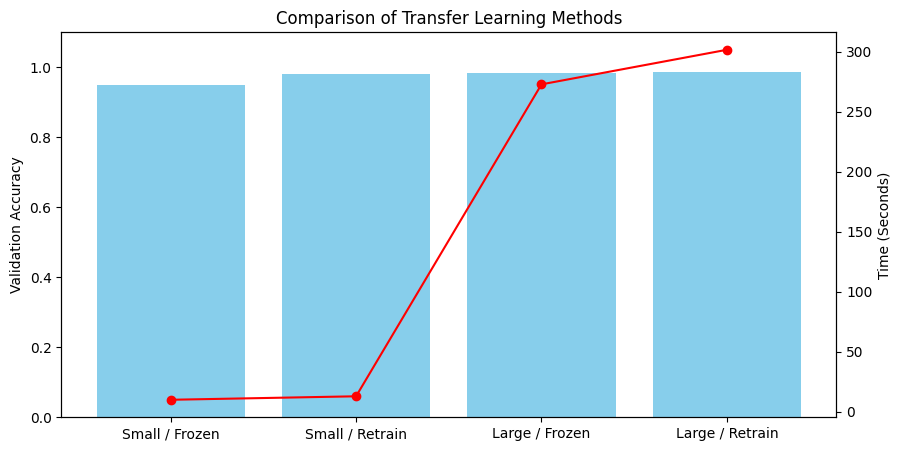

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Create a Table for the Report
df = pd.DataFrame(results)
print("\n--- Project Summary Table ---")
print(df)

# 2. Visualize the Trade-off
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Accuracy (Bars)
ax1.bar(df['name'], df['accuracy'], color='skyblue', label='Accuracy')
ax1.set_ylabel('Validation Accuracy')
ax1.set_ylim(0, 1.1)

# Plot Time (Line)
ax2 = ax1.twinx()
ax2.plot(df['name'], df['time'], color='red', marker='o', label='Time (s)')
ax2.set_ylabel('Time (Seconds)')

plt.title('Comparison of Transfer Learning Methods')
plt.show()